## Estrella

In [1]:
import numpy as np
import matplotlib.patches as patches
from matplotlib.path import Path
import matplotlib.pyplot as plt

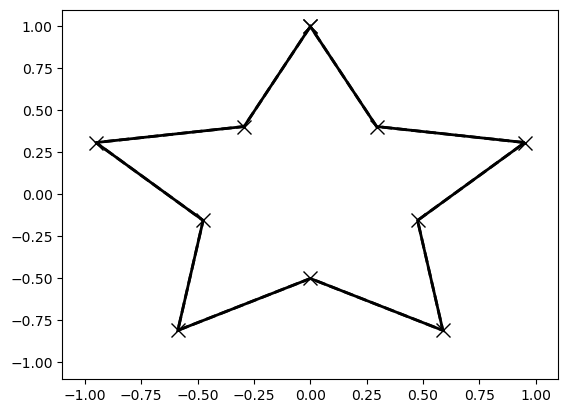

In [2]:
path = Path.unit_regular_star( 5, innerCircle=0.5)

fig, ax = plt.subplots()
patch = patches.PathPatch(path, facecolor='none', lw=2)
ax.add_patch(patch)

xs, ys = zip(*path.vertices)
ax.plot(xs, ys, 'x--', lw=2, color='black', ms=10)

ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
plt.show()

In [3]:
N = int( 10000 / (len(path.vertices) - 1) )
puntos = []
normales = []
for i in range( len(path.vertices) - 1 ):
    directions = np.tile(path.vertices[i+1] - path.vertices[i], (N,1))
    puntos.append( 
        np.tile( path.vertices[i], (N,1) ) + np.linspace(0,1,N)[..., None] * directions
    )

    normales.append(
        np.concatenate( [ directions[:, 1][...,None],(-1 * directions[:,0])[...,None] ], axis=1 )
    )

In [4]:
puntos = np.concatenate( puntos ) * 0.75
normales  = np.concatenate( normales )

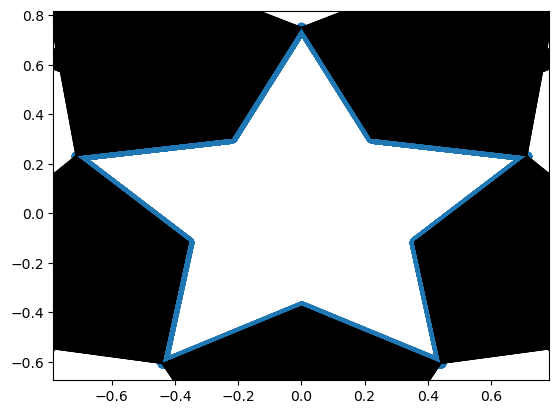

In [5]:
plt.scatter( puntos[:,0], puntos[:,1] )

U = normales[:, 0]# - puntos[:, 0]  # Vector components along x-axis
V = normales[:, 1]# - puntos[:, 1]  # Vector components along y-axis

# Create the quiver plot
plt.quiver(puntos[:,0], puntos[:,1], U, V, angles='xy', scale_units='xy', scale=1)

In [6]:
np.savez( 'data/star/star_pc.npz',points=puntos, normals=normales )

In [7]:
np.load( 'data/star/star_pc.npz')['points'].shape

(10000, 2)

## Circulo

In [8]:
import numpy as np
import matplotlib.pyplot as plt

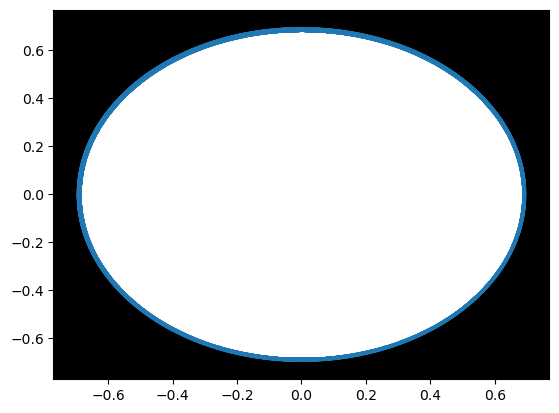

In [9]:
N = 5000
r = 0.7
theta = np.linspace(0, 2 * np.pi, N)

points = np.concatenate( [ np.sin(theta)[...,None] * r, np.cos(theta)[...,None] * r ], axis=1 )
normals = np.concatenate( [ np.sin(theta)[...,None] , np.cos(theta)[...,None] ], axis=1 )

plt.scatter( points[:,0], points[:,1] )
plt.quiver(points[:,0], points[:,1], normals[:,0], normals[:,1], angles='xy', scale_units='xy', scale=1)

In [10]:
np.savez( 'data/circle/point_cloud.npz', points=points, normals=normals )

## El chat

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


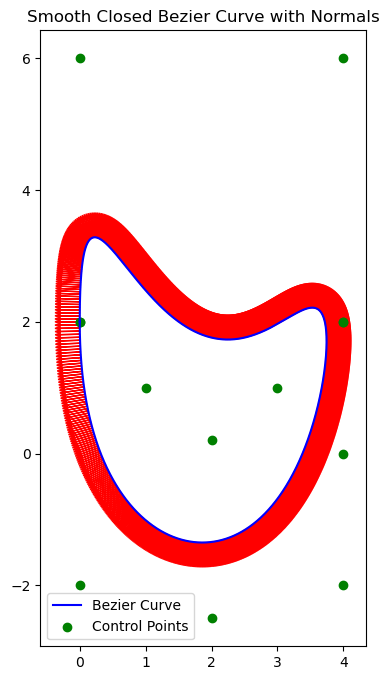

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from scipy.spatial import Voronoi, Delaunay, voronoi_plot_2d
import math

# Function to compute Bernstein polynomials
def bernstein_poly(i, n, t):
    return (math.factorial(n) / 
            (math.factorial(i) * math.factorial(n - i))) * (t ** i) * ((1 - t) ** (n - i))

# Bezier curve function
def bezier_curve(control_points, n_points=100):
    n = len(control_points) - 1
    t = np.linspace(0.0, 1.0, n_points)
    curve = np.zeros((n_points, 2))
    for i in range(n + 1):
        curve += np.outer(bernstein_poly(i, n, t), control_points[i])
    return curve

# Tangent vector computation
def compute_tangents(control_points, n_points=100):
    n = len(control_points) - 1
    t = np.linspace(0.0, 1.0, n_points)
    tangents = np.zeros((n_points, 2))
    for i in range(n):
        tangents += np.outer((n * bernstein_poly(i, n - 1, t)), (control_points[i + 1] - control_points[i]))
    return tangents

# Normal vector computation (orthogonal to tangent)
def compute_normals(tangents):
    normals = np.zeros_like(tangents)
    normals[:, 0] = -tangents[:, 1]
    normals[:, 1] = tangents[:, 0]
    # Normalize normals
    norm = np.linalg.norm(normals, axis=1)
    normals = normals / norm[:, np.newaxis]
    return normals

control_points = np.array([
    [0.0, 2.0],    # Top-left of the "U"
    [0.0, -2.0],   # Left curve down
    [2.0, -2.5],   # Bottom of the "U"
    [4.0, -2.0],   # Right curve up
    [4.0, 0.0],    # Top-right of the "U"
    [4.0, 2.0],
    [4.0, 6.0],
    [4.0, 2.0],    
    [3, 1],    # Top-left inward control for closure
    [2, 0.2],
    [1, 1],
    [1, 1],
    [0,2]
])

# Create symmetry for smooth closure
# Ensure the first and last control points are symmetric around the start/end point
#control_points = np.vstack([control_points, [0.0, 0.0]])  # Close the loop

# Adjust second and second-last points for smoothness (C1 continuity)
control_points[-2] = 2 * control_points[-1] - control_points[1]  # Make the last control point mirror the first

# Generate the Bezier curve
n_points = 10000
curve = bezier_curve(control_points, n_points)

# Compute tangents and normals
tangents = compute_tangents(control_points, n_points)
normals = -1 * compute_normals(tangents)

# Plotting the curve and normals
plt.figure(figsize=(8, 8))
plt.plot(curve[:, 0], curve[:, 1], label='Bezier Curve', color='blue')

# Sample and plot normals at every 10th point
for i in range(0, n_points, 10):
    plt.arrow(curve[i, 0], curve[i, 1], normals[i, 0] * 0.3, normals[i, 1] * 0.3, color='red', head_width=0.05)

plt.scatter(control_points[:, 0], control_points[:, 1], color='green', label='Control Points')
plt.legend()
plt.title('Smooth Closed Bezier Curve with Normals')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [12]:
np.min( curve, axis=0), np.max(curve,axis=0)

curve -= np.min(curve,axis=0)
curve /= np.max( curve, axis=0) / 2
curve -= np.ones((1,2))
curve *= 0.65

np.min( curve, axis=0), np.max(curve,axis=0)

(array([-0.65, -0.65]), array([0.65, 0.65]))

In [15]:
curve.shape

(10000, 2)

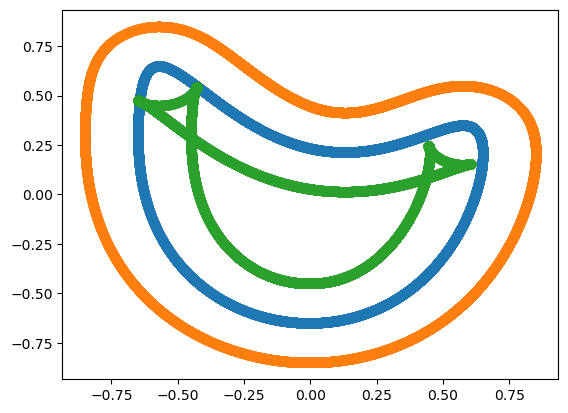

In [19]:
plt.scatter( *curve.T )
plt.scatter( *(curve + 0.2 * normals ).T )
plt.scatter( *(curve - 0.2 * normals ).T )

/tmp/ipykernel_2588733/75870094.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


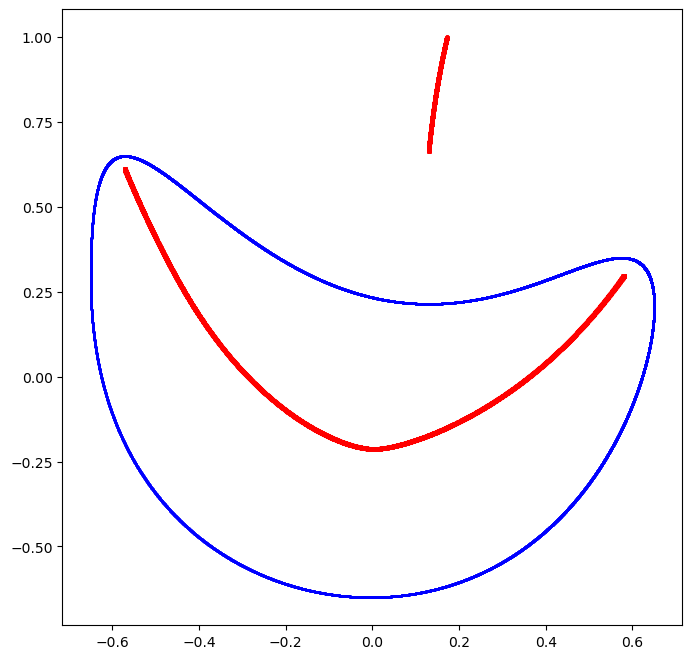

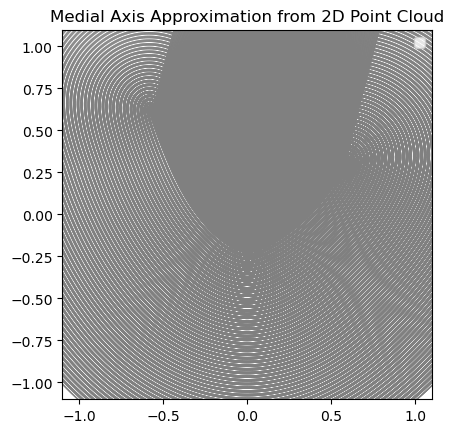

In [7]:
from scipy.spatial import Voronoi, voronoi_plot_2d

# Sample point cloud representing a closed curve (normalized to [-1, 1] x [-1, 1])
# Replace this with your own "curve" data
#curve = np.random.rand(200, 2) * 2 - 1  # Example point cloud in [-1, 1] range

# Compute the Voronoi diagram for the points on the curve
vor = Voronoi(curve)

# Filter Voronoi vertices that are inside the normalized square [-1, 1] x [-1, 1]
medial_axis = np.array([v for v in vor.vertices if -1 <= v[0] <= 1 and -1 <= v[1] <= 1])

# Plot the curve and the medial axis approximation
plt.figure(figsize=(8, 8))
plt.plot(curve[:, 0], curve[:, 1], 'b.', markersize=2, label="Curve Points")
plt.scatter(medial_axis[:, 0], medial_axis[:, 1], color='red', s=5, label="Medial Axis Approximation")

# Optionally, plot the Voronoi diagram for reference
voronoi_plot_2d(vor, show_vertices=False, show_points=False, line_colors='gray', line_width=0.5)

# Customize plot
plt.legend()
plt.title("Medial Axis Approximation from 2D Point Cloud")
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [8]:
medial_axis.shape

(12612, 2)

In [9]:
np.savez( 
    'data/bezier2/bezier2_pc.npz',
    points=curve,
    normals=normals / np.linalg.norm(normals, axis=1) [...,None], 
    medial_axis=medial_axis[ np.random.choice( np.arange(len(medial_axis)), 1000, replace=False)]
)